In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
import os
import pandas as pd

# Chemin basé sur l'emplacement du notebook
current_dir = os.path.dirname(os.path.abspath("__file__")) 
train_data_path = os.path.join(current_dir, "../data/train_df.csv")
test_data_path = os.path.join(current_dir, "../data/test_df.csv")

In [3]:
# Charger le fichier
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

**2. Pre-processing**

Because of the different scales between each features, we want to scale our dataset.

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
scaler = StandardScaler()
columns_to_scale = ['Factor_A', 'Factor_B', 'Factor_C', 'Factor_D', 'Factor_E', 'Factor_F']
df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])

In [6]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [7]:
for df in [df_train, df_test]:
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Weekday'] = df['Date'].dt.weekday

preparation modelisation

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [9]:
target_column = "Electric_Consumption"  
feature_columns_train = [col for col in df_train.columns if col not in ['Date', target_column]] 
feature_columns_test = [col for col in df_test.columns if col not in ['Date']]

In [10]:
# Préparation des séries temporelles
train_target = df_train[target_column]
train_features = df_train[feature_columns_train]
test_features = df_test[feature_columns_test]

**3. Modelisation**

**3.1 SARIMA**

In [11]:
# Ajouter les features exogènes (indépendantes) au modèle SARIMA
exog_train = train_features.values
exog_test = test_features.values

# from pmdarima import auto_arima

# # Recherche automatique des meilleurs paramètres SARIMA
# best_model = auto_arima(
#     train_target,
#     exogenous=exog_train,
#     seasonal=True,
#     m=12,  # Période saisonnière
#     start_p=0, max_p=3,  # Intervalle pour p
#     start_q=0, max_q=3,  # Intervalle pour q
#     start_P=0, max_P=2,  # Intervalle pour P
#     start_Q=0, max_Q=2,  # Intervalle pour Q
#     d=None, D=None,  # Détection automatique de d et D
#     trace=True,  # Affiche les résultats pendant la recherche
#     error_action='ignore',  # Ignorer les erreurs pour certaines configurations
#     stepwise=True  # Recherche itérative
# )

# # Résumé du modèle
# print(best_model.summary())

C:\Users\Loïc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


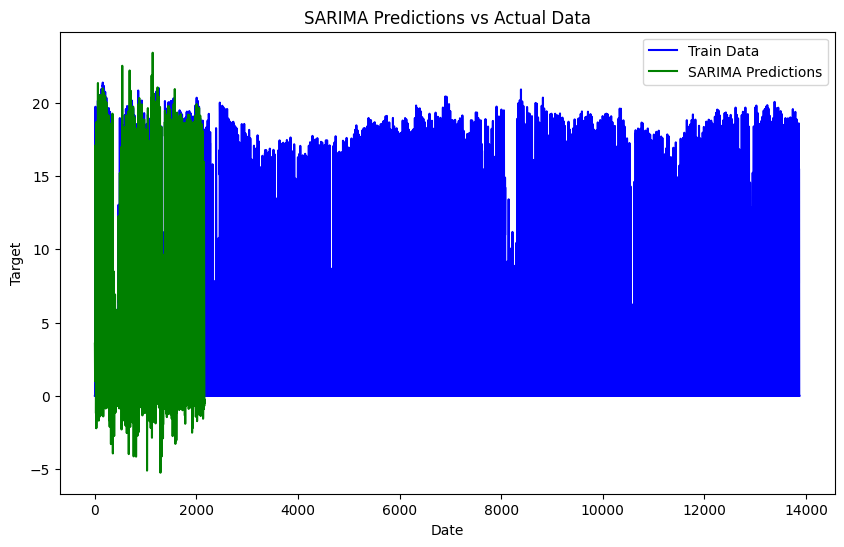

In [12]:
#configuration modèle SARIMA
sarima_model = SARIMAX(
    endog=train_target,
    exog=exog_train,
    order=(3, 0, 2),            #paramètres ARIMA (p, d, q)
    seasonal_order=(2, 0, 1, 12),  #paramètres saisonniers (P, D, Q, S)
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit(disp=False)

predictions = sarima_result.predict(
    exog=exog_test
)

#ajout predictions dans le dataset
df_test['Electric_Consumption'] = predictions

#visualisation résultats
plt.figure(figsize=(10, 6))
plt.plot(df_train[target_column], label='Train Data', color='blue')
plt.plot(df_test['Electric_Consumption'], label='SARIMA Predictions', color='green')
plt.legend()
plt.title('SARIMA Predictions vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Target')
plt.show()


In [13]:
#on retire "Date" comme index pour pouvoir étudier correctement le dataset avec LSTM ensuite
current_dir = os.path.dirname(os.path.abspath("__file__")) 
results_path = os.path.join(current_dir, "../data/predictions.csv")
df_test[['Date', 'Electric_Consumption']].to_csv(results_path, index=False)

**3.2 LSTM**

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [15]:
df_test = df_test.sort_values(by='Date')

In [18]:
# Fonction pour créer des séquences
def create_sequences(X, y, time_steps):
    if len(X) <= time_steps:
        raise ValueError("Le paramètre `time_steps` est trop grand pour la longueur des données.")
    
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)


# Paramètre de séquencement (nombre de pas de temps)
time_steps = 10

# Créer les séquences
train_features, train_target = create_sequences(train_features, train_target, time_steps)
X_seq = []
for i in range(len(test_features) - time_steps):
        X_seq.append(test_features[i:i + time_steps])
test_features = np.array(X_seq)

Shape initiale de train_features : (13872, 9)
Shape initiale de test_features : (2160, 9)
Shape finale de train_features : (13862, 10, 9)
Shape finale de test_features : (2150, 10, 9)


In [19]:
# Construire le modèle LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Une sortie pour la prédiction de la target

# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraîner le modèle
model.fit(train_features, train_target, epochs=20, batch_size=32)

Epoch 1/20


C:\Users\Loïc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 47.1717
Epoch 2/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11.4704
Epoch 3/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0344
Epoch 4/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4459
Epoch 5/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.3467
Epoch 6/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.9239
Epoch 7/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5168
Epoch 8/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.2148
Epoch 9/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8781
Epoch 10/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8986
Epoch 11/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3015
Epoch 12/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.5568
Epoch 13/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3953
Epoch 14/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4465
Epoch 15/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.965

In [20]:
# Prédire sur l'ensemble de test
predicted = model.predict(test_features)

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [22]:
import numpy as np

# Si `predicted` est à 2 dimensions (par exemple, shape (2150, 1))
if len(predicted) < len(df_test):
    # Créer un padding de même forme que les prédictions
    padding = np.full((len(df_test) - len(predicted), predicted.shape[1]), np.nan)  # Padding avec NaN
    predicted = np.vstack([padding, predicted])  # Empiler verticalement

# Vérification de la taille finale
assert len(predicted) == len(df_test), "Les tailles de `predicted` et `df_test` ne correspondent toujours pas."

# Ajouter les prédictions au DataFrame
df_test['Electric_Consumption'] = predicted.squeeze()  # Retirer les dimensions inutiles si nécessaire

# Remplir les valeurs manquantes ou non valides
df_test['Electric_Consumption'] = df_test['Electric_Consumption'].fillna(0)  # Remplacer NaN par 0 ou une autre valeur

# Exportation au format CSV
current_dir = os.path.dirname(os.path.abspath("__file__")) 
results_path = os.path.join(current_dir, "../data/predictions2.csv")
df_test[['Date', 'Electric_Consumption']].to_csv(results_path, index=False)
print("Exportation réussie.")

Exportation réussie.
